# Aggregating Data and Building the Model

In [1]:
# import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import datetime
from datetime import date, timedelta
import ast
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error

## 1. Aggregating Data

In [2]:
# Sentiment data
sentiment_data = pd.read_csv("final_sentiment_data.csv")
# MF NAVs
mf_nav = pd.read_csv("AMFI_Reports.csv")
# Sensex data
sensex_data = pd.read_csv("CSVForDate.csv")

In [3]:
sentiment_data

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Date,Headlines,Processed_headlines,Positive Scores,Negative Scores,Neutral Scores,Compound Scores
0,0,0,0,2022-06-08,"['Why waste waste if you can get wasted?', 'Ji...","['waste waste get wasted', 'jiobp give monthly...",0.110808,0.073270,0.815934,0.044268
1,1,1,1,2022-06-09,['Centre may express concern over narcotics sm...,['centre may express concern narcotic smugglin...,0.148782,0.076613,0.774605,0.093870
2,2,2,2,2022-06-10,"['Tea exporters buoyed by robust demand, expec...",['tea exporter buoyed robust demand expect mil...,0.130858,0.098172,0.770968,0.036928
3,3,3,3,2022-06-11,"[""Meta probing Sheryl Sandberg's use of compan...",['meta probing sheryl sandbergs use company re...,0.105064,0.102094,0.792850,-0.008721
4,4,4,4,2022-06-12,['India’s driving the R&D wheel at Mercedes-Be...,"['india driving rd wheel mercedesbenz', 'rule ...",0.100937,0.124604,0.774458,-0.042125
...,...,...,...,...,...,...,...,...,...,...
726,726,726,726,2024-06-03,"['What drove growth in FY24', 'BJP worker alle...","['drove growth fy', 'bjp worker allegedly behe...",0.140942,0.073648,0.785410,0.094385
727,727,727,727,2024-06-04,"['10 Best Mayonnaise of (2024) For quick, tast...","['best mayonnaise quick tasty meal', 'gen z he...",0.167072,0.078026,0.754926,0.156232
728,728,728,728,2024-06-05,['How will new moon in Gemini affect you? Peop...,['new moon gemini affect people zodiac sign ma...,0.162856,0.077198,0.759950,0.122053
729,729,729,729,2024-06-06,['Nisaba Godrej quits VIP Board over differenc...,"['nisaba godrej quits vip board difference', '...",0.157706,0.077356,0.764926,0.100804


In [4]:
mf_nav

,Net Asset Value,Repurchase Price,Sale Price,NAV date
0,48.5691,NaN,NaN,01-Jan-21
1,49.1367,NaN,NaN,04-Jan-21
2,49.3475,NaN,NaN,05-Jan-21
3,49.3500,NaN,NaN,06-Jan-21
4,49.3713,NaN,NaN,07-Jan-21
...,...,...,...,...
840,84.4289,NaN,NaN,03-Jun-24
841,80.6477,NaN,NaN,04-Jun-24
842,83.1941,NaN,NaN,05-Jun-24
843,83.9987,NaN,NaN,06-Jun-24


In [5]:
sensex_data

,Date,Open,High,Low,Close
0,08-Jun-22,16743.46,16773.05,16552.32,16611.74
1,09-Jun-22,16517.01,16747.58,16493.99,16735.73
2,10-Jun-22,16577.80,16586.87,16443.15,16470.88
3,13-Jun-22,16154.96,16155.96,15967.70,16051.03
4,14-Jun-22,15956.47,16147.67,15934.82,16014.37
...,...,...,...,...,...
490,03-Jun-24,24629.93,24678.32,24357.25,24570.88
491,04-Jun-24,24538.98,24538.98,22334.49,23063.21
492,05-Jun-24,23374.23,23938.24,22918.86,23893.21
493,06-Jun-24,24124.04,24233.50,23964.33,24143.80


In [6]:
# convert every date column to datetime format in order to do an inner join
sentiment_data['Date'] = pd.to_datetime(sentiment_data['Date'], format='%Y-%m-%d')
mf_nav['NAV date'] = pd.to_datetime(mf_nav['NAV date'], format='%d-%b-%y')
sensex_data['Date'] = pd.to_datetime(sensex_data['Date'], format='%d-%b-%y')

In [7]:
sentiment_data.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'Date', 'Headlines',
       'Processed_headlines', 'Positive Scores', 'Negative Scores',
       'Neutral Scores', 'Compound Scores'],
      dtype='object')

In [8]:
mf_nav.columns

Index(['Net Asset Value', 'Repurchase Price', 'Sale Price', 'NAV date'], dtype='object')

In [9]:
sensex_data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close'], dtype='object')

In [10]:
mf_nav_dropped = mf_nav.drop(columns=['Repurchase Price', 'Sale Price'], axis = 1)

In [11]:
senti_dropped = sentiment_data.drop(columns=['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'Headlines', 'Processed_headlines'], axis = 1)

In [12]:
senti_dropped

,Date,Positive Scores,Negative Scores,Neutral Scores,Compound Scores
0,2022-06-08,0.110808,0.073270,0.815934,0.044268
1,2022-06-09,0.148782,0.076613,0.774605,0.093870
2,2022-06-10,0.130858,0.098172,0.770968,0.036928
3,2022-06-11,0.105064,0.102094,0.792850,-0.008721
4,2022-06-12,0.100937,0.124604,0.774458,-0.042125
...,...,...,...,...,...
726,2024-06-03,0.140942,0.073648,0.785410,0.094385
727,2024-06-04,0.167072,0.078026,0.754926,0.156232
728,2024-06-05,0.162856,0.077198,0.759950,0.122053
729,2024-06-06,0.157706,0.077356,0.764926,0.100804


In [13]:
mf_nav_dropped

,Net Asset Value,NAV date
0,48.5691,2021-01-01
1,49.1367,2021-01-04
2,49.3475,2021-01-05
3,49.3500,2021-01-06
4,49.3713,2021-01-07
...,...,...
840,84.4289,2024-06-03
841,80.6477,2024-06-04
842,83.1941,2024-06-05
843,83.9987,2024-06-06


In [14]:
sensex_data

,Date,Open,High,Low,Close
0,2022-06-08,16743.46,16773.05,16552.32,16611.74
1,2022-06-09,16517.01,16747.58,16493.99,16735.73
2,2022-06-10,16577.80,16586.87,16443.15,16470.88
3,2022-06-13,16154.96,16155.96,15967.70,16051.03
4,2022-06-14,15956.47,16147.67,15934.82,16014.37
...,...,...,...,...,...
490,2024-06-03,24629.93,24678.32,24357.25,24570.88
491,2024-06-04,24538.98,24538.98,22334.49,23063.21
492,2024-06-05,23374.23,23938.24,22918.86,23893.21
493,2024-06-06,24124.04,24233.50,23964.33,24143.80


Now we shall merge the three dataframes, first with the sentiment data and Sensex data, then with 

In [15]:
first_merged = pd.merge(senti_dropped, sensex_data, how="inner")

In [16]:
first_merged

,Date,Positive Scores,Negative Scores,Neutral Scores,Compound Scores,Open,High,Low,Close
0,2022-06-08,0.110808,0.073270,0.815934,0.044268,16743.46,16773.05,16552.32,16611.74
1,2022-06-09,0.148782,0.076613,0.774605,0.093870,16517.01,16747.58,16493.99,16735.73
2,2022-06-10,0.130858,0.098172,0.770968,0.036928,16577.80,16586.87,16443.15,16470.88
3,2022-06-13,0.128198,0.081780,0.790026,0.056796,16154.96,16155.96,15967.70,16051.03
4,2022-06-14,0.128470,0.069632,0.801916,0.064638,15956.47,16147.67,15934.82,16014.37
...,...,...,...,...,...,...,...,...,...
490,2024-06-03,0.140942,0.073648,0.785410,0.094385,24629.93,24678.32,24357.25,24570.88
491,2024-06-04,0.167072,0.078026,0.754926,0.156232,24538.98,24538.98,22334.49,23063.21
492,2024-06-05,0.162856,0.077198,0.759950,0.122053,23374.23,23938.24,22918.86,23893.21
493,2024-06-06,0.157706,0.077356,0.764926,0.100804,24124.04,24233.50,23964.33,24143.80


In [17]:
dataset = pd.merge(first_merged, mf_nav_dropped, left_on='Date', right_on='NAV date', how='inner')

In [18]:
# now we can drop the "NAV date" column as it is the same as the "Date" column
dataset = dataset.drop(columns=['NAV date'], axis=1)

In [19]:
dataset

,Date,Positive Scores,Negative Scores,Neutral Scores,Compound Scores,Open,High,Low,Close,Net Asset Value
0,2022-06-08,0.110808,0.073270,0.815934,0.044268,16743.46,16773.05,16552.32,16611.74,56.7042
1,2022-06-09,0.148782,0.076613,0.774605,0.093870,16517.01,16747.58,16493.99,16735.73,57.0767
2,2022-06-10,0.130858,0.098172,0.770968,0.036928,16577.80,16586.87,16443.15,16470.88,56.3738
3,2022-06-13,0.128198,0.081780,0.790026,0.056796,16154.96,16155.96,15967.70,16051.03,55.0474
4,2022-06-14,0.128470,0.069632,0.801916,0.064638,15956.47,16147.67,15934.82,16014.37,55.0272
...,...,...,...,...,...,...,...,...,...,...
484,2024-06-03,0.140942,0.073648,0.785410,0.094385,24629.93,24678.32,24357.25,24570.88,84.4289
485,2024-06-04,0.167072,0.078026,0.754926,0.156232,24538.98,24538.98,22334.49,23063.21,80.6477
486,2024-06-05,0.162856,0.077198,0.759950,0.122053,23374.23,23938.24,22918.86,23893.21,83.1941
487,2024-06-06,0.157706,0.077356,0.764926,0.100804,24124.04,24233.50,23964.33,24143.80,83.9987


Let us observe the plots between each feature and the NAV column

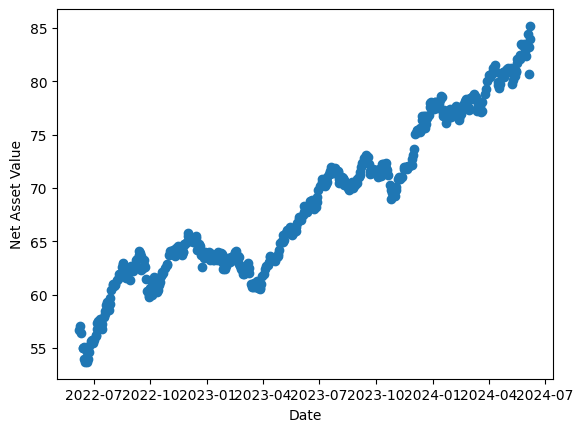

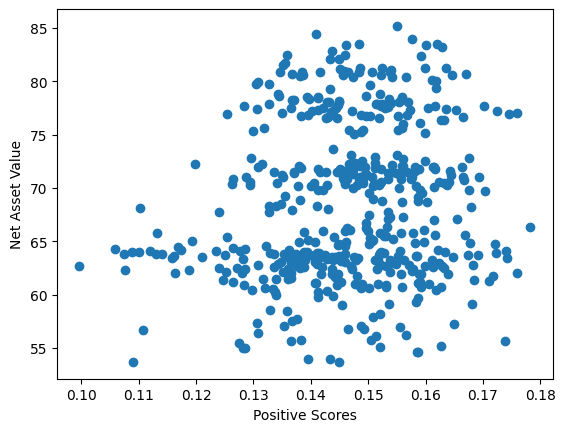

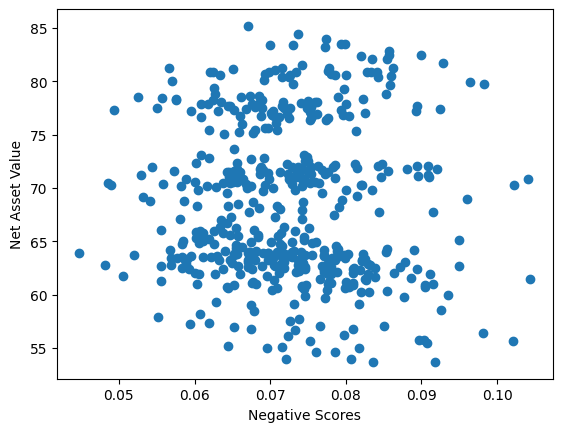

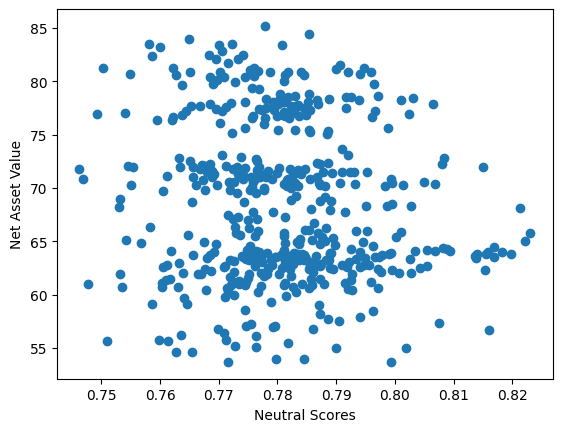

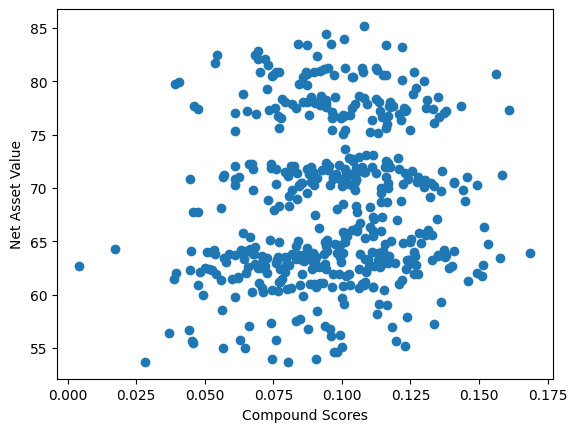

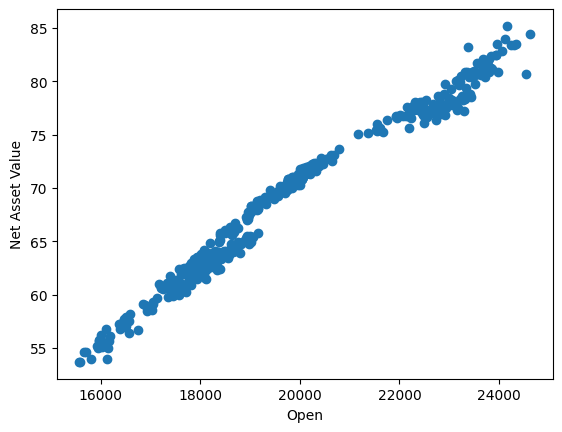

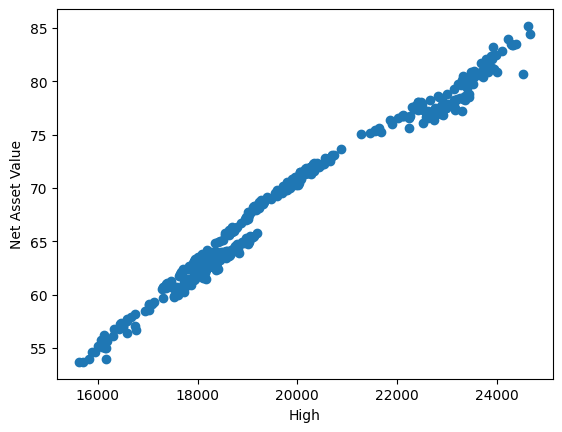

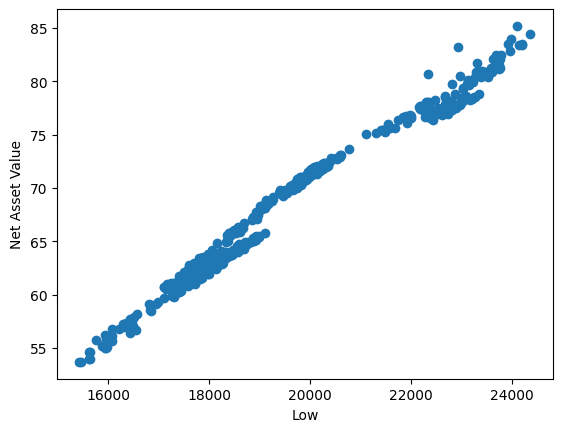

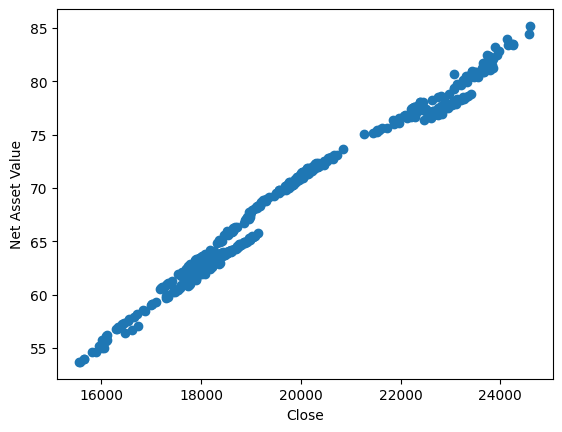

In [20]:
columns = ['Date', 'Positive Scores', 'Negative Scores', 'Neutral Scores', 'Compound Scores', 'Open', 'High', 'Low', 'Close']
for col in columns:
    plt.scatter(dataset[col], dataset['Net Asset Value'])
    plt.ylabel('Net Asset Value')
    plt.xlabel(col)
    plt.show()

We finally have our dataset. Now we preprocess the dataset and move on to the ML part of the project.

While there does not appear to be a lot of relation between sentiment scores and NAV, however, let us try to see how models work to analyze the depth of this influence.

## 2. Machine learning on the final dataset

In [21]:
X = dataset.iloc[:, 1:-1]
y = dataset.iloc[:, -1]

In [22]:
X

,Positive Scores,Negative Scores,Neutral Scores,Compound Scores,Open,High,Low,Close
0,0.110808,0.073270,0.815934,0.044268,16743.46,16773.05,16552.32,16611.74
1,0.148782,0.076613,0.774605,0.093870,16517.01,16747.58,16493.99,16735.73
2,0.130858,0.098172,0.770968,0.036928,16577.80,16586.87,16443.15,16470.88
3,0.128198,0.081780,0.790026,0.056796,16154.96,16155.96,15967.70,16051.03
4,0.128470,0.069632,0.801916,0.064638,15956.47,16147.67,15934.82,16014.37
...,...,...,...,...,...,...,...,...
484,0.140942,0.073648,0.785410,0.094385,24629.93,24678.32,24357.25,24570.88
485,0.167072,0.078026,0.754926,0.156232,24538.98,24538.98,22334.49,23063.21
486,0.162856,0.077198,0.759950,0.122053,23374.23,23938.24,22918.86,23893.21
487,0.157706,0.077356,0.764926,0.100804,24124.04,24233.50,23964.33,24143.80


In [23]:
y

0      56.7042
1      57.0767
2      56.3738
3      55.0474
4      55.0272
        ...   
484    84.4289
485    80.6477
486    83.1941
487    83.9987
488    85.1902
Name: Net Asset Value, Length: 489, dtype: float64

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

In [25]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [26]:
y_train = sc_y.fit_transform(y_train.values.reshape(-1, 1))
y_test = sc_y.transform(y_test.values.reshape(-1, 1))

### Random Forest

In [27]:
from sklearn.ensemble import RandomForestRegressor
regressor_rf = RandomForestRegressor(n_estimators=100)
regressor_rf.fit(X_train, y_train)

c:\Users\aprat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor()

In [28]:
y_pred_rf = regressor_rf.predict(X_test)

In [29]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_test, y_pred_rf))

0.0849505094500646

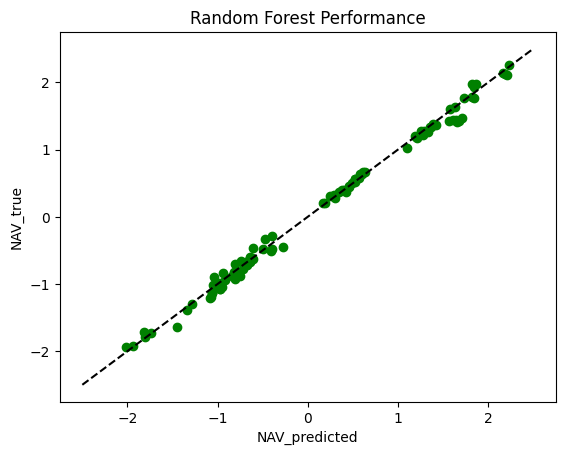

In [30]:
plt.scatter(y_pred_rf, y_test, color = 'green')
plt.xlabel("NAV_predicted")
plt.ylabel("NAV_true")
plt.plot([-2.5, 2.5], [-2.5, 2.5], '--k')
plt.title("Random Forest Performance")
plt.show()

### ANN

In [31]:
X_train_ann, X_test_ann, y_train_ann, y_test_ann = train_test_split(X, y, test_size= 0.2, random_state= 42)
X_train_ann, X_val_ann, y_train_ann, y_val_ann = train_test_split(X_train_ann, y_train_ann, test_size=0.2, random_state= 42)
sc_X_ann = StandardScaler()
sc_y_ann = StandardScaler()
X_train_ann = sc_X.fit_transform(X_train_ann)
X_test_ann = sc_X.transform(X_test_ann)
X_val_ann = sc_X.transform(X_val_ann)
y_train_ann = sc_y.fit_transform(y_train_ann.values.reshape(-1, 1))
y_test_ann = sc_y.transform(y_test_ann.values.reshape(-1, 1))
y_val_ann = sc_y.transform(y_val_ann.values.reshape(-1, 1))

In [32]:
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(25, input_dim = 8, activation = 'relu'))
#ann.add(tf.keras.layers.Dense(units = 45, activation = 'relu'))
#ann.add(tf.keras.layers.BatchNormalization())
#ann.add(tf.keras.layers.Dense(units = 32, activation = 'relu'))
#ann.add(tf.keras.layers.BatchNormalization())
#ann.add(tf.keras.layers.Dense(units = 16, activation = 'relu'))
#ann.add(tf.keras.layers.Dense(units = 8, activation = 'relu'))
ann.add(tf.keras.layers.Dense(units = 1, activation = 'relu'))

In [33]:
ann.compile(optimizer='adam', loss='mean_squared_error')

In [34]:
ann.fit(X_train_ann, y_train_ann, validation_data=(X_val_ann, y_val_ann), epochs=100, verbose=1)

Epoch 1/100

10/10 [==============================] - 1s 24ms/step - loss: 1.3930 - val_loss: 1.4020
Epoch 2/100
10/10 [==============================] - 0s 8ms/step - loss: 1.1217 - val_loss: 1.1013
Epoch 3/100
10/10 [==============================] - 0s 7ms/step - loss: 0.8803 - val_loss: 0.8492
Epoch 4/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6791 - val_loss: 0.6715
Epoch 5/100
10/10 [==============================] - 0s 6ms/step - loss: 0.5664 - val_loss: 0.5901
Epoch 6/100
10/10 [==============================] - 0s 6ms/step - loss: 0.5082 - val_loss: 0.5550
Epoch 7/100
10/10 [==============================] - 0s 6ms/step - loss: 0.4819 - val_loss: 0.5394
Epoch 8/100
10/10 [==============================] - 0s 6ms/step - loss: 0.4690 - val_loss: 0.5323
Epoch 9/100
10/10 [==============================] - 0s 6ms/step - loss: 0.4621 - val_loss: 0.5286
Epoch 10/100
10/10 [==============================] - 0s 6ms/step - loss: 0.4587 - val_loss: 0.5260
Epoch 1

Regardless of our efforts to optimize the model, the val_loss stagnates around 0.51-0.52. Let us run the model on the test data just to be sure.

In [35]:
y_pred_ann = ann.predict(X_test_ann)

4/4 [==============================] - 0s 2ms/step


In [36]:
np.sqrt(mean_squared_error(y_test_ann, y_pred_ann))

0.7197328945813454

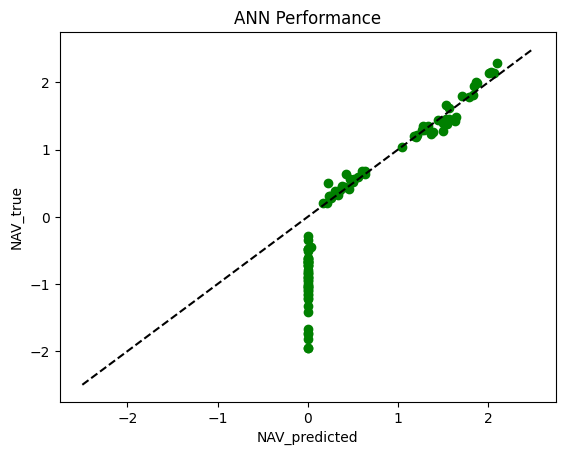

In [37]:
plt.scatter(y_pred_ann, y_test_ann, color = 'green')
plt.xlabel("NAV_predicted")
plt.ylabel("NAV_true")
plt.plot([-2.5, 2.5], [-2.5, 2.5], '--k')
plt.title("ANN Performance")
plt.show()

Clearly, ANN isn't suited while considering the size of our data. Several more datapoints might help with the mean squared error, however, we already have a much better performing model with the Random Forest regression model.

### SVM

In [38]:
from sklearn.svm import SVR
regressor_svr = SVR(kernel='rbf')
regressor_svr.fit(X_train, y_train)

c:\Users\aprat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR()

In [39]:
y_pred_svr = regressor_svr.predict(X_test)

In [40]:
np.sqrt(mean_squared_error(y_test, y_pred_svr))

0.11978383784729109

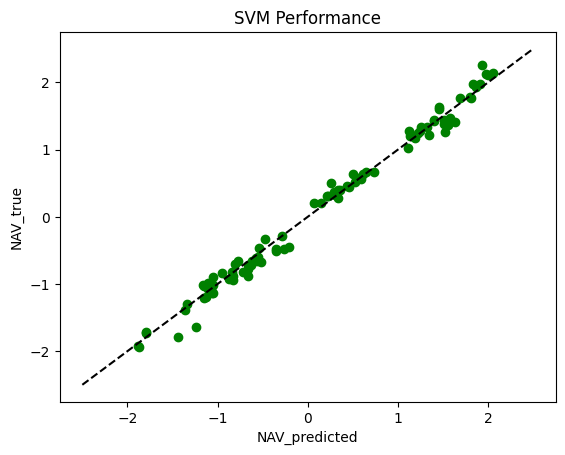

In [41]:
plt.scatter(y_pred_svr, y_test, color = 'green')
plt.xlabel("NAV_predicted")
plt.ylabel("NAV_true")
plt.plot([-2.5, 2.5], [-2.5, 2.5], '--k')
plt.title("SVM Performance")
plt.show()

### Linear Regression

In [42]:
from sklearn.linear_model import LinearRegression
regressor_linear = LinearRegression()
regressor_linear.fit(X_train, y_train)

LinearRegression()

In [44]:
y_pred_linear = regressor_linear.predict(X_test)

In [45]:
np.sqrt(mean_squared_error(y_test, y_pred_linear))

0.14571568198268428

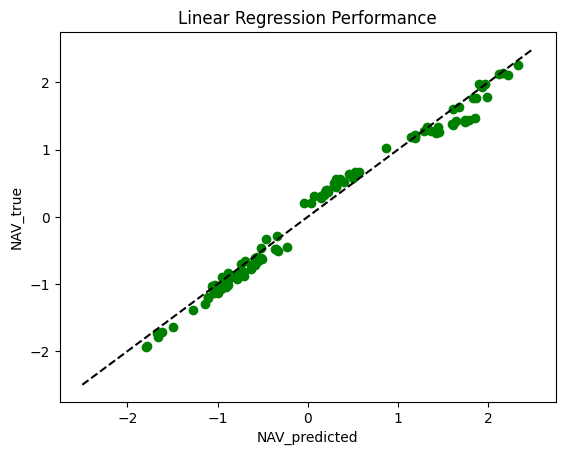

In [46]:
plt.scatter(y_pred_linear, y_test, color = 'green')
plt.xlabel("NAV_predicted")
plt.ylabel("NAV_true")
plt.plot([-2.5, 2.5], [-2.5, 2.5], '--k')
plt.title("Linear Regression Performance")
plt.show()

## CONCLUSION

We finally check the correlation matrix. This will show the influence of the sentiment scores on the NAV values.

In [48]:
dataset.corr()

C:\Users\aprat\AppData\Local\Temp\ipykernel_14224\2191645083.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataset.corr()


,Positive Scores,Negative Scores,Neutral Scores,Compound Scores,Open,High,Low,Close,Net Asset Value
Positive Scores,1.000000,-0.357313,-0.730285,0.835525,0.117894,0.120071,0.119994,0.123096,0.148345
Negative Scores,-0.357313,1.000000,-0.377042,-0.757535,-0.008326,-0.012199,-0.022093,-0.023013,-0.034309
Neutral Scores,-0.730285,-0.377042,1.000000,-0.274534,-0.110540,-0.109868,-0.102574,-0.104978,-0.121850
Compound Scores,0.835525,-0.757535,-0.274534,1.000000,0.091461,0.093417,0.094618,0.097847,0.124375
Open,0.117894,-0.008326,-0.110540,0.091461,1.000000,0.999384,0.998205,0.997845,0.987597
High,0.120071,-0.012199,-0.109868,0.093417,0.999384,1.000000,0.998207,0.998864,0.987831
Low,0.119994,-0.022093,-0.102574,0.094618,0.998205,0.998207,1.000000,0.999177,0.989694
Close,0.123096,-0.023013,-0.104978,0.097847,0.997845,0.998864,0.999177,1.000000,0.989631
Net Asset Value,0.148345,-0.034309,-0.121850,0.124375,0.987597,0.987831,0.989694,0.989631,1.000000


Why do sentiment scores have low correlation even though sentiments do drive the market? 
An answer lies in the manner of collection of the dataset. We collected every single headline from The Economic Times, regardless of content. The project aimed to see the extent of dependence of the market on general news, and so the correlation with the average sentiments over all types of news is less.

Due to time constraints, I have ended the project here for the present. Further developments would include filtering through the pulled news headlines to focus only on financial news. At that stage, the project would become centred around the financial and stock market domain. At this stage, the sentiment scores pulled from the news can be used in any domain the user wishes.

Another development to be implemented after the one mentioned above would be using grid search to optimize hyper-parameters. Since the sentiment scores do not have a particularly significant correlation with the NAV when compared to the Sensex data, I would like to tune hyper-parameters once the correlation is improved. Currently, tuning the hyper-parameters does not result in any significant improvements of the model.

Finally, one thing I would like to include in later versions is an automated version of this project that would evaluate scores and predict NAV automatically each day, which can be further linked to a Tableau/PowerBI dashboard to create a user friendly interface.